# Topic Modeling for App Reviews
### Natural Language Processing (NLP) Project — Korean Financial Mobile Applications
*Author: Yongjun (Andrew) Lee*, Korea Securities Finance Corporation (KSFC)

---

## Project Overview

This notebook implements **BERTopic** for analyzing Korean mobile banking app reviews. The analysis identifies key themes in user feedback to inform UX improvements and strategic decision-making.

**Key Components:**
- **Data Source**: Google Play Store reviews for Korean financial mobile applications
- **Text Processing**: Komoran morphological analyzer for Korean tokenization
- **Topic Modeling**: BERTopic with multilingual BERT embeddings
- **Sentiment Analysis**: Polarity scoring integrated with topic clusters
- **Visualizations**: Interactive Plotly charts and statistical summaries

**Business Impact**: This analysis supports KSFC's digital transformation strategy by systematically identifying user pain points, satisfaction drivers, and priority areas for mobile platform enhancement.

---

### Research Questions
1. What are the main topics discussed in mobile banking app reviews?
2. Which topics correlate with positive vs. negative user sentiment?
3. What specific features drive user satisfaction or frustration?
4. How can topic modeling inform UX prioritization for KSFC's mobile applications?

In [1]:
import warnings, logging, sys, os

# 1. Suppress all Python-level DeprecationWarnings globally
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 2. Disable noisy loggers commonly triggered inside Jupyter
logging.getLogger("asyncio").setLevel(logging.ERROR)
logging.getLogger("tornado").setLevel(logging.ERROR)
logging.getLogger("jupyter_client").setLevel(logging.ERROR)

# 3. Redirect stderr to /dev/null to silence residual warnings
#sys.stderr = open(os.devnull, "w")

# 4. Explicitly ignore the specific datetime.utcnow() deprecation warning
warnings.filterwarnings(
    "ignore",
    message="datetime.datetime.utcnow() is deprecated",
    category=DeprecationWarning
)

print("Deprecation warnings (utcnow) completely suppressed.")

Deprecation warnings (utcnow) completely suppressed.


### Environment Setup

In [2]:
# Install all required dependencies
!pip install --upgrade pip
!pip install "scipy<1.13"  # rollback to compatible version
!pip install pandas numpy
!pip install kornounextractor
!pip install konlpy

# Install BERTopic and dependencies
!pip install bertopic sentence-transformers umap-learn hdbscan
!pip install pyLDAvis==3.4.1
!pip install openpyxl  # for reading Excel files
!pip install JPype1  # required for KoNLPy (Java bridge)

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import jpype

import pandas as pd
import numpy as np

import html
import re

from datetime import datetime
from pprint import pprint

from konlpy.tag import Komoran

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

## 1. Data Cleaning and Normalization
This section cleans raw text from mobile app user reviews by:
- Removing HTML entities and URLs  
- Normalizing spacing, casing, and symbols  
- Standardizing domain-specific terminology (e.g., “공동인증서” → “Digital Certificate”)  

In [4]:
def display_features(features, feature_names):
    df = pd.DataFrame(data=features, columns=feature_names)
    print(df)

def get_sentences( text ) :
    # 0) Restore HTML entities
    s = html.unescape(text)

    # 1) Remove URLs -> keep a single space
    s = re.sub(r"https?://\S+|www\.\S+", " ", s)

    # 2) Control chars -> space
    s = re.sub(r'[\t\r\f\n]+', ' ', s)

    # 3) Domain-specific replacements (before heavy cleaning)
    replace_patterns = [
        (r'공인\s*인증\s*서',  '공동인증서'),
        (r'공동\s*인증\s*서',  '공동인증서'),
        (r'금융\s*인증\s*서',  '금융인증서'),
        (r'공인\s*인증(?!서)',  '공동인증서'),
        (r'공동\s*인증(?!서)',  '공동인증서'),
        (r'금융\s*인증(?!서)',  '금융인증서'),
        (r'간편\s*비밀번호',   '간편인증'),
        (r'패턴\s*인증',       '간편인증'),
        (r'바이오\s*인증|지문\s*인증|얼굴\s*인증', '바이오인증'),
        (r'본인\s*(인증|확인)', '본인인증'),
        (r'계좌\s*인증|1원\s*인증', '계좌인증'),
        (r'비번',              '비밀번호'),
        (r'\bID\b',            'ID'),
        (r'\bPW\b',            '비밀번호'),
        (r'\bUI\b',            'UI'),
        (r'\bUX\b',            'UX'),
        (r'어플|애플리케이션|에플리케이션|\bAPP\b', '앱'),
        (r'한국\s*증권\s*금융|한국\s*금융\s*증권|증권\s*금융|증금', '한국증권금융'),
        (r'튕기', '튕김'),
        (r'공공\s*기관',  '공공기관'),
        (r'타\s*기관',    '타기관'),
        (r'고객\s*정보',  '고객정보'),
        (r'(?<![가-힣A-Za-z0-9])우리\s*사주(?![가-힣A-Za-z0-9])', '우리사주'),
        (r'(?<![가-힣A-Za-z0-9])(비대면\s*가입|회원\s*가입|상품\s*가입)(?![가-힣A-Za-z0-9])', '가입'),
        (r'(?<![가-힣A-Za-z0-9])주민\s*등록증(?![가-힣A-Za-z0-9])', '신분증'),
        (r'(?<![가-힣A-Za-z0-9])운전\s*면허증(?![가-힣A-Za-z0-9])', '신분증'),
        (r'우리사주\s*뱅킹|사주\s*뱅킹', '우리사주뱅킹'),
        (r'인터넷\s*뱅킹',  '인터넷뱅킹'),
        (r'모바일\s*뱅킹',  '모바일뱅킹'),
        (r'슈레기|쉬레기임|쉬레기|RUBBISH|쓰래기', '쓰레기'),
        (r'에러', '오류'),
    ]
    for patt, repl in replace_patterns:
        s = re.sub(patt, repl, s, flags=re.IGNORECASE)

    # 3.5) '이정도~ / 그정도~ / 저정도~' 결합 교정: 앞의 지시어와 '정도' 사이를 띄워 주기
    s = re.sub(r'(?<![가-힣A-Za-z0-9])([이그저])정도', r'\1 정도', s)

    # 3.6) '정도' + 어미/조사 결합도 분할(선택): Komoran에 분절 힌트 제공
    s = re.sub(r'정도(면|는|도|까|까지|라|라고|의|에|에서|로)', r'정도 \1', s)

    # 4) Drop noisy symbols but keep word chars / Korean / spaces
    s = re.sub(r'[^\w가-힣 ]', ' ', s)

    # 5) Normalize whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    # 6) Uppercase only ASCII letters (keep Korean as-is)
    s = re.sub(r'[A-Za-z]+', lambda m: m.group(0).upper(), s)

    return s

# Extract POS tags from Komoran
def get_pos_tags(komoran, docs):
    morph_list = []
    for sentence in docs:
        s = get_sentences(sentence)  # ⬅️ 정규화 적용
        if not s:
            continue
        try:
            morph_list.append(komoran.pos(s))
        except Exception as e:
            print('[POS ERROR]:', s, e)

    return morph_list


# Extract Korean common and proper nouns (NNG, NNP)
def get_NNG_NNP_words(morphs_list, stop_words_list=None):
    if stop_words_list is None:
        stop_words_list = set()
    NNG_NNP_words = []
    for morphs in morphs_list:
        item = []
        for word, tag in morphs:
            if tag in ('NNG', 'NNP'):
                if len(word) <= 1 or word.isnumeric():   # 항상 길이 필터 적용
                    continue
                if word in stop_words_list:
                    continue
                item.append(word)
        NNG_NNP_words.append(item)
    return NNG_NNP_words


# 1) Domain-specific compound noun dictionary (final forms only)
TERM_TO_TAG = {
    "인증서": "NNG",
    "인증센터": "NNG",
    "공동인증서": "NNP",
    "금융인증서": "NNG",
    "간편인증": "NNG",
    "바이오인증": "NNG",
    "본인인증": "NNG",
    "신분증": "NNG",
    "운전면허증": "NNP",
    "주민등록증": "NNP",
    "한국증권금융": "NNP",
    "우리사주": "NNG",
    "계좌인증": "NNG",
    "1원인증": "NNG",
    "인터넷뱅킹": "NNG",
    "우리사주뱅킹": "NNG",
    "모바일뱅킹": "NNG",
    "파킹통장": "NNG",
    "무결성": "NNG",
    "리뉴얼": "NNG",
    "로그인": "NNG",
    "비밀번호":"NNG",
    "버퍼링":"NNG",
    "비대면":"NNG",
    #"회원가입":"NNG",
    #"상품가입":"NNG",
    "가입":"NNG",
    "공공기관":"NNG",
    "금융기관":"NNG",
    "타기관":"NNG",
    "고객정보":"NNG",

    "재설치":"NNG",
    "재시도": "NNG",

    "UI":"NNG",
    "UX":"NNG",
    "ID": "NNG"
}

# Normalize candidate tokens (fix spacing or Jamo issues)
def _normalize_candidate(cand: str) -> str:

    cand = cand.replace(" ", "")
    cand = cand.replace("이ㄴ", "인")
    cand = cand.replace("비대이면", "비대면")
    cand = cand.replace("로그인창", "로그인창")
    cand = cand.replace("로그인", "로그인")
    cand = cand.replace("버퍼링", "버퍼링")
    cand = cand.replace("비밀번호", "비밀번호")
    cand = cand.replace("아이디", "ID")
    return cand

# Combine tokens into a surface form without spaces
def _join_surface(tokens):
    return ''.join(w.replace(' ', '') for w, _ in tokens)

# List of Korean postpositions (from longest to shortest)
JOSA = [
    "으로써","으로서","으로","으로는","에게서","에게","에서","에는","에는",
    "까지","부터","라도","라도","라도","라고","처럼","만큼",
    "에게","에게는","에게도","보다","보다도",
    "이라고","이라고는","이란","이랑","으로도",
    "이가","이는","이도","이를","으로서","으로써",
    "이가","은","는","이","가","을","를","과","와","도","만","에","의",
    "처럼","만큼","보다"
]

def split_na_with_josa(token):
    w, t = token
    if t != "NA":
        return [token]
    for js in sorted(JOSA, key=len, reverse=True):
        if w.endswith(js) and len(w) > len(js):
            stem = w[:-len(js)]
            stem_tag = "NNG" if stem == "앱" else "NNG"
            josa_tag = "JKS" if js in ["이","가","이가"] else \
                       "JKO" if js in ["을","를","이를"] else \
                       "JX"  if js in ["은","는","도","만"] else \
                       "JKB" if js in ["에","에서","에게","으로","으로는","처럼","만큼","보다","까지","부터"] else \
                       "JC"  if js in ["과","와","이랑"] else "JX"
            return [(stem, stem_tag), (js, josa_tag)]
    return [token]

# -------- Global configuration (to avoid re-creation on every call) --------
SMALL_GLUE = {
    ("로","그","인"): "로그인",
    ("버","퍼","링"): "버퍼링",
    ("비","밀","번","호"): "비밀번호",
    ("아","이","디"): "아이디",
    ("로그","인"): "로그인",
    ("버퍼","링"): "버퍼링",
    ("비","밀","번호"): "비밀번호",

    ("공공","기관"): "공공기관",
    ("금융","기관"): "금융기관",
    ("타","기관"): "타기관",

    ("재","설치"): "재설치",
    ("재","시도"): "재시도",

    # Extend as needed
    ("로그","인창"): "로그인창",
    ("로그","인후"): "로그인후",
}

def merge_compound_terms(pos_seq, term_to_tag=TERM_TO_TAG, max_len=5):
    """
    Merge or correct compound terms within POS-tagged sequences.
    e.g., [('공동','NNG'), ('이','VCP'), ('ㄴ','ETM'), ('증서','NNP')] → [('공동인증서','NNP')]
    """
    merged = []
    i, n = 0, len(pos_seq)
    while i < n:
        found = False

        # 1) Domain dictionary window match (max_len -> 2)
        for L in range(min(max_len, n - i), 1, -1):
            cand = ''.join(w for w, _ in pos_seq[i:i+L])
            cand_norm = _normalize_candidate(cand)
            if cand_norm in term_to_tag:
                merged.append((cand_norm, term_to_tag[cand_norm]))
                i += L
                found = True
                break
        if found:
            continue

        # 2) (Optional) SMALL_GLUE - only if it matches exactly the surface forms
        for L in range(min(4, n - i), 2, -1):
            chunk = tuple(w for w, _ in pos_seq[i:i+L])
            if chunk in SMALL_GLUE:
                glued = _normalize_candidate(SMALL_GLUE[chunk])
                tag = term_to_tag.get(glued, "NNG")
                merged.append((glued, tag))
                i += L
                found = True
                break
        if found:
            continue

        # 3) Default: keep token (with NA+josa split)
        w, t = pos_seq[i]
        parts = split_na_with_josa((w.replace(' ', ''), t)) if t == "NA" else [(w.replace(' ', ''), t)]
        for pw, pt in parts:
            if pw == "앱" and pt in ("NA","NNP","NNG"):
                merged.append(("앱", "NNG"))
            else:
                merged.append((pw, pt))
        i += 1

    return merged

## 2. Configuration & Data Loading

The following configuration parameters control the entire analysis pipeline. Adjust these values based on your dataset and requirements:

- `NUM_TOPICS`: Target number of topics (3-5 recommended for app reviews)
- `NO_BELOW`: Minimum term frequency threshold
- `min_topic_size`: Minimum documents per topic cluster

In [5]:
# ----------------------------------------------------
# [1] Configuration (Reusable by only modifying file paths & key parameters)
# ----------------------------------------------------
EXCEL_PATH      = '/data/all_reviews.xlsx'
STOP_WORDS_PATH = '/stop_words_list.txt'
DICTIONARY_PATH = '/dictionary.txt'
DATA_PATH       = '/data/'
RESULT_PATH       = '/result/'
SHEET_NAME   = 'Sheet1'
TEXT_COL     = 'content'            # Column name containing review text
NUM_TOPICS   = 3                    # Number of topics (recommended: 3 or 4)
NUM_WORDS    = 10                   # Number of representative words per topic
RANDOM_STATE = 42                   # Random seed for reproducibility
USE_MULTICORE = False               # Set True for large datasets to enable multi-core processing

df = pd.read_excel(os.getcwd() + EXCEL_PATH, sheet_name=SHEET_NAME)
print(df.head())

         date          author  \
0  2025-08-27             훈승채   
1  2025-08-25  CHANG YOUP LEE   
2  2025-08-25             정연균   
3  2025-08-25    Chunghui Lee   
4  2025-07-31             이영송   

                                             content  rating        store  
0                                 너무 편리하고 좋은 것 같습니다.       5  Google Play  
1                                                좋아요       5  Google Play  
2                                                좋아요       5  Google Play  
3                                         잘 쓰고 있습니다.       5  Google Play  
4  개정되고 편의성이 높아졌습니다! 상품 주요 정보도 한 눈에 보이고, 주사용 메뉴도 ...       5  Google Play  


In [6]:
# =====================
# [3] Load Stopword List
# =====================
with open(os.getcwd() + STOP_WORDS_PATH, 'r', encoding='utf-8') as f:
    stop_words_set = { line.strip() for line in f if line.strip() }

# Preview (show 10 sorted examples)
print(sorted(list(stop_words_set))[:10])
print("# N of stopwords : ", len(stop_words_set))

['가요', '간만', '개도', '건지', '사람', '사용', '시간', '실행', '아무', '업데이트']
# N of stopwords :  23


In [7]:
# =====================
# [4] Cleasing words
# =====================
my_data_list=list()

for sentence in df[TEXT_COL].fillna('') :
    # Clean each review sentence using the get_sentences() function
    my_data_list.append(get_sentences(sentence))
my_data_list[:100]

['너무 편리하고 좋은 것 같습니다',
 '좋아요',
 '좋아요',
 '잘 쓰고 있습니다',
 '개정되고 편의성이 높아졌습니다 상품 주요 정보도 한 눈에 보이고 주사용 메뉴도 첫화면에 노출되니 쓰기 편하고 좋습니다',
 '원활하게 비대면 가입을 할 수 있어서 감사합니다 ㅎㅎ',
 '별점 한개도 아깝습니다 앱 다시 만드세요 신분증 인증 40회만에 인증 성공 매번 이동 시 로그인 필수고 계좌인증 시 계좌 앱 인증번호 확인 후 증권사 앱 들어가면 무한 버퍼링 결국 앱 종료 밑에 글도 버퍼링이 심하다는 내용이 있는데 개선좀 해주세요',
 '무결성 검증실패',
 '과거에 비해서 많이 좋아졌내요 시중 금융권 앱과 비교되는 부분이 많았는데 디자인적으로나 기능적으로나 편하게 사용할 수 있어서 좋습니다 수고하세요',
 '도대체 신분증 어케등록함 30분내내 찍어올려도인증이안되네',
 '보기가 편하고 편리합니다',
 '파킹통장 금리가 좋네요',
 '생각보다 좋은거 같네요 잘 사용해보겠습니다',
 '리뉴얼되고 나서 더 편하고 나아졌어요',
 '최고네요',
 '대출 신상품 좋네요 앱도 좋아졌고 ㅋㅋㅋ',
 '시스템 개편이후 서비스가 넘 좋아졌습니다 굿 입니다요',
 '개편후 사용자 편의성이 너무 좋습니다 VERY VERY GOOD입니다',
 '훨씬 좋아졌어요 앱 계속 쓰고 있는데 아주 만족해요',
 '한국증권금융앱이 달라졌네요 전보다 훨씬 직관적인거 같아 좋습니다',
 '비밀번호를 몰라서 임시비밀번호로 로그인했는데 이전비밀번호를 넣어야한다는데 어떻게 해야하나요',
 '쓸 때마다 업데이트하라고 나오니깐 너무 짜증납니다 너무 자주 업데이트하지 마세요 꼭 필요한 것만 모아서 한 번에 해주셨으면 좋겠습니다',
 '여러 메뉴들이 잘 정리되어 있어서 편리한듯',
 '잘쓰고 있씁뉘다',
 '금리가 좋아서 자주 이용하고 있는데 최근 화면이나 편의성이 많이 개선되어서 사용하기 좋네요',
 'UI가 보기 편하고 도움이 됩니다',
 '사용하기 좋은 앱입니다',
 '앱 관리좀 합시다',
 '가끔 들어가는

In [8]:
try:
    from kornounextractor.noun_extractor import extract
    korean_noun_set = set()
    for content in my_data_list:
        # Use the preprocessed version for cleaner input
        clean = get_sentences(content)
        # The extract() function can take raw text,
        # but using the cleaned version helps reduce noise.
        nouns = extract(clean, freq=1)
        if nouns:
            korean_noun_set.update(nouns)

    # Remove irrelevant or noisy tokens
    for junk in ("CO", "HTTPS", "HTTP"):
        if junk in korean_noun_set:
            korean_noun_set.discard(junk)
except Exception:
    korean_noun_set = set()

print(korean_noun_set)

set()


In [9]:
# NNG: General noun (common noun)
# NNP: Proper noun (named entity)

os.makedirs(os.path.dirname(os.getcwd() + DICTIONARY_PATH), exist_ok=True)

with open(os.getcwd() + DICTIONARY_PATH, 'w', encoding='utf8') as f:
    for word in sorted(korean_noun_set):
        f.write(f"{word}\tNNG\n")

    # Add domain-specific financial terms and standard forms
    # Note: Only standardized terms are included.
    # For example, “공인인증서” is unified as “공동인증서” during preprocessing,
    # so both are not required in the dictionary.
    add_dic = [
        ("고객정보","NNG"), ("공동인증서","NNP"), ("금융인증서","NNG"),
        ("간편인증","NNG"), ("바이오인증","NNG"), ("본인인증","NNG"),
        ("운전면허증","NNP"), ("주민등록증","NNP"), ("한국증권금융","NNP"),
        ("우리사주","NNG"), ("계좌인증","NNG"), ("1원인증","NNG"),
        ("계좌번호","NNG"), ("버퍼링","NNG"), ("인터넷뱅킹","NNG"),
        ("우리사주뱅킹","NNG"), ("모바일뱅킹","NNG"), ("파킹통장","NNG"),
        ("편의성","NNG"), ("비대면","NNG"), ("리뉴얼","NNG"),
        ("무결성","NNG"), ("로그인","NNG"), ("인증서","NNG"),
        ("인증센터","NNG"),
        ("가입","NNG"), #("회원가입","NNG"), ("상품가입","NNG"),
        ("공공기관","NNG"), ("금융기관","NNG"), ("타기관","NNG"),
        ("재설치","NNG"), ("재시도","NNG"),
        ("UI","NNG"), ("UX","NNG")
    ]

    # Write additional dictionary entries
    for w, t in add_dic:
        f.write(f"{w}\t{t}\n")

In [10]:
komoran = Komoran(userdic=DICTIONARY_PATH)

# Clean sentences using custom regex-based normalization
# Converts HTML entities, removes URLs/symbols, and unifies domain terminology
cleaned_docs = [get_sentences(x) for x in my_data_list]
print(cleaned_docs[:100])

['너무 편리하고 좋은 것 같습니다', '좋아요', '좋아요', '잘 쓰고 있습니다', '개정되고 편의성이 높아졌습니다 상품 주요 정보도 한 눈에 보이고 주사용 메뉴도 첫화면에 노출되니 쓰기 편하고 좋습니다', '원활하게 비대면 가입을 할 수 있어서 감사합니다 ㅎㅎ', '별점 한개도 아깝습니다 앱 다시 만드세요 신분증 인증 40회만에 인증 성공 매번 이동 시 로그인 필수고 계좌인증 시 계좌 앱 인증번호 확인 후 증권사 앱 들어가면 무한 버퍼링 결국 앱 종료 밑에 글도 버퍼링이 심하다는 내용이 있는데 개선좀 해주세요', '무결성 검증실패', '과거에 비해서 많이 좋아졌내요 시중 금융권 앱과 비교되는 부분이 많았는데 디자인적으로나 기능적으로나 편하게 사용할 수 있어서 좋습니다 수고하세요', '도대체 신분증 어케등록함 30분내내 찍어올려도인증이안되네', '보기가 편하고 편리합니다', '파킹통장 금리가 좋네요', '생각보다 좋은거 같네요 잘 사용해보겠습니다', '리뉴얼되고 나서 더 편하고 나아졌어요', '최고네요', '대출 신상품 좋네요 앱도 좋아졌고 ㅋㅋㅋ', '시스템 개편이후 서비스가 넘 좋아졌습니다 굿 입니다요', '개편후 사용자 편의성이 너무 좋습니다 VERY VERY GOOD입니다', '훨씬 좋아졌어요 앱 계속 쓰고 있는데 아주 만족해요', '한국증권금융앱이 달라졌네요 전보다 훨씬 직관적인거 같아 좋습니다', '비밀번호를 몰라서 임시비밀번호로 로그인했는데 이전비밀번호를 넣어야한다는데 어떻게 해야하나요', '쓸 때마다 업데이트하라고 나오니깐 너무 짜증납니다 너무 자주 업데이트하지 마세요 꼭 필요한 것만 모아서 한 번에 해주셨으면 좋겠습니다', '여러 메뉴들이 잘 정리되어 있어서 편리한듯', '잘쓰고 있씁뉘다', '금리가 좋아서 자주 이용하고 있는데 최근 화면이나 편의성이 많이 개선되어서 사용하기 좋네요', 'UI가 보기 편하고 도움이 됩니다', '사용하기 좋은 앱입니다', '앱 관리좀 합시다', '가끔 들어가는데 디자인이 깔끔해졌네요', '앱이 훨씬 세련되고 

java.io.FileNotFoundException: /dictionary.txt (No such file or directory)
	at java.base/java.io.FileInputStream.open0(Native Method)
	at java.base/java.io.FileInputStream.open(FileInputStream.java:216)
	at java.base/java.io.FileInputStream.<init>(FileInputStream.java:157)
	at java.base/java.io.FileInputStream.<init>(FileInputStream.java:111)
	at java.base/java.io.FileReader.<init>(FileReader.java:60)
	at kr.co.shineware.nlp.komoran.core.Komoran.setUserDic(Komoran.java:616)


## 3. Korean Text Preprocessing

Korean text requires specialized preprocessing due to its agglutinative morphology. Key steps:

1. **Morphological Analysis**: Using Komoran to extract morphemes
2. **Noun Extraction**: Filter for common nouns (NNG) and proper nouns (NNP)
3. **Compound Term Handling**: Custom dictionary for domain-specific terms
4. **Stopword Filtering**: Remove generic terms that don't contribute to topics

**Domain-Specific Terms**:
- Financial: 공동인증서 (public certificate), 금융인증서 (financial certificate)
- Technical: 로그인 (login), 비밀번호 (password), 버퍼링 (buffering)
- Banking: 파킹통장 (parking account), 계좌인증 (account verification)

In [11]:
# Apply Komoran POS tagging to extract part-of-speech information
morphs_list = get_pos_tags(komoran, cleaned_docs)

# Merge domain-specific compound terms for better topic coherence
morphs_list = [merge_compound_terms(seq) for seq in morphs_list]

print(morphs_list[:])

[[('너무', 'MAG'), ('편리', 'NNG'), ('하', 'XSV'), ('고', 'EC'), ('좋', 'VA'), ('은', 'ETM'), ('것', 'NNB'), ('같', 'VA'), ('습니다', 'EC')], [('좋', 'VA'), ('아요', 'EC')], [('좋', 'VA'), ('아요', 'EC')], [('잘', 'MAG'), ('쓰', 'VV'), ('고', 'EC'), ('있', 'VV'), ('습니다', 'EC')], [('개정', 'NNG'), ('되', 'XSV'), ('고', 'EC'), ('편의', 'NNG'), ('성', 'XSN'), ('이', 'JKS'), ('높', 'VA'), ('아', 'EC'), ('지', 'VX'), ('었', 'EP'), ('습니다', 'EC'), ('상품', 'NNG'), ('주요', 'XR'), ('정보', 'NNG'), ('도', 'JX'), ('한', 'MM'), ('눈', 'NNG'), ('에', 'JKB'), ('보이', 'VV'), ('고', 'EC'), ('주사', 'NNG'), ('용', 'XSN'), ('메뉴', 'NNP'), ('도', 'JX'), ('첫', 'MM'), ('화면', 'NNG'), ('에', 'JKB'), ('노출', 'NNG'), ('되', 'XSV'), ('니', 'EC'), ('쓰기', 'NNP'), ('편하', 'VA'), ('고', 'EC'), ('좋', 'VA'), ('습니다', 'EC')], [('원활', 'NNG'), ('하', 'XSV'), ('게', 'EC'), ('비대면', 'NNG'), ('가입', 'NNG'), ('을', 'JKO'), ('하', 'VV'), ('ㄹ', 'ETM'), ('수', 'NNB'), ('있', 'VV'), ('어서', 'EC'), ('감사', 'NNG'), ('하', 'XSV'), ('ㅂ니다', 'EC'), ('ㅎㅎ', 'NA')], [('별점', 'NNG'), ('한', 'MM'), ('개도', 'N

In [12]:
# Extract common and proper nouns from the morphological analysis results
# - NNG: general/common nouns
# - NNP: proper nouns
# - stop_words_set: user-defined stopword list to filter out irrelevant tokens
NN_words = get_NNG_NNP_words(morphs_list, stop_words_list=stop_words_set)

print(NN_words[:100])

[[], [], [], [], ['개정', '편의', '상품', '정보', '주사', '메뉴', '노출', '쓰기'], ['원활', '비대면', '가입', '감사'], ['별점', '신분증', '인증', '인증', '성공', '이동', '로그인', '필수', '계좌인증', '계좌', '인증', '번호', '증권사', '무한', '버퍼링', '종료', '버퍼링', '내용', '개선'], ['무결성', '검증', '실패'], ['과거', '시중', '금융', '비교', '부분', '디자인', '기능', '수고'], ['신분증', '등록', '인증', '이안'], [], ['파킹통장', '금리'], ['생각'], ['리뉴얼'], ['최고'], ['대출', '신상품'], ['시스템', '개편', '서비스'], ['개편', '사용자', '편의'], ['만족'], ['한국증권금융앱', '직관'], ['비밀번호', '임시', '비밀번호', '로그인', '이전', '비밀번호'], ['짜증', '필요'], ['메뉴', '정리'], [], ['금리', '좋아서', '최근', '편의', '개선'], ['도움'], [], ['관리'], ['디자인'], ['안정', '개선', '전반', '인터페이스', '직관', '앞으로', '예정'], ['평상시', '편의', '인터페이스', '은행앱', '비교', '손색', '금리', '예정'], ['리뉴얼', '편의'], ['모바일뱅킹', '최근', '이전', '현상', '디자인', '불편', '이제', '문제', '해결', '이미지', '전반', '현대', '느낌', '이전', '인증', '등록', '오류', '발생', '스트레스', '지금', '부분', '개선', '사용자', '입장', '안정', '환경', '조성'], ['직관', '대출', '상품'], ['리뉴얼', '사용성'], ['안정', '공공기관', '디자인', '개선', '와이드', '예수금', '금리', '전체', '만족도'], ['해진', '거래'], ['원격조정앱', '감지

In [13]:
# Remove completely empty tokenized documents before creating the dictionary
NN_words = [doc for doc in NN_words if doc]
print(NN_words[:100])

[['개정', '편의', '상품', '정보', '주사', '메뉴', '노출', '쓰기'], ['원활', '비대면', '가입', '감사'], ['별점', '신분증', '인증', '인증', '성공', '이동', '로그인', '필수', '계좌인증', '계좌', '인증', '번호', '증권사', '무한', '버퍼링', '종료', '버퍼링', '내용', '개선'], ['무결성', '검증', '실패'], ['과거', '시중', '금융', '비교', '부분', '디자인', '기능', '수고'], ['신분증', '등록', '인증', '이안'], ['파킹통장', '금리'], ['생각'], ['리뉴얼'], ['최고'], ['대출', '신상품'], ['시스템', '개편', '서비스'], ['개편', '사용자', '편의'], ['만족'], ['한국증권금융앱', '직관'], ['비밀번호', '임시', '비밀번호', '로그인', '이전', '비밀번호'], ['짜증', '필요'], ['메뉴', '정리'], ['금리', '좋아서', '최근', '편의', '개선'], ['도움'], ['관리'], ['디자인'], ['안정', '개선', '전반', '인터페이스', '직관', '앞으로', '예정'], ['평상시', '편의', '인터페이스', '은행앱', '비교', '손색', '금리', '예정'], ['리뉴얼', '편의'], ['모바일뱅킹', '최근', '이전', '현상', '디자인', '불편', '이제', '문제', '해결', '이미지', '전반', '현대', '느낌', '이전', '인증', '등록', '오류', '발생', '스트레스', '지금', '부분', '개선', '사용자', '입장', '안정', '환경', '조성'], ['직관', '대출', '상품'], ['리뉴얼', '사용성'], ['안정', '공공기관', '디자인', '개선', '와이드', '예수금', '금리', '전체', '만족도'], ['해진', '거래'], ['원격조정앱', '감지', '앱인지', '처리'], ['쓰레기'], ['

## 4. BERTopic Model Training

**Why BERTopic?**
- Superior to LDA for short documents (reviews)
- Captures semantic similarity through BERT embeddings
- Handles Korean text effectively with multilingual models
- Produces more interpretable topic clusters

**Model Configuration**:
- Embedding: `paraphrase-multilingual-MiniLM-L12-v2`
- Min cluster size: 10 documents
- Vectorizer: TF-IDF with Korean noun tokens

In [14]:
# ----------------------------------------------------
# [1] Prepare Input for BERTopic
# ----------------------------------------------------
# BERTopic expects a list of strings (documents)
# We'll join the tokenized nouns back into space-separated strings
docs_for_bertopic = [' '.join(tokens) for tokens in NN_words if tokens]

print(f"Total documents for BERTopic: {len(docs_for_bertopic)}")
print("Sample document:", docs_for_bertopic[:100])


Total documents for BERTopic: 317
Sample document: ['개정 편의 상품 정보 주사 메뉴 노출 쓰기', '원활 비대면 가입 감사', '별점 신분증 인증 인증 성공 이동 로그인 필수 계좌인증 계좌 인증 번호 증권사 무한 버퍼링 종료 버퍼링 내용 개선', '무결성 검증 실패', '과거 시중 금융 비교 부분 디자인 기능 수고', '신분증 등록 인증 이안', '파킹통장 금리', '생각', '리뉴얼', '최고', '대출 신상품', '시스템 개편 서비스', '개편 사용자 편의', '만족', '한국증권금융앱 직관', '비밀번호 임시 비밀번호 로그인 이전 비밀번호', '짜증 필요', '메뉴 정리', '금리 좋아서 최근 편의 개선', '도움', '관리', '디자인', '안정 개선 전반 인터페이스 직관 앞으로 예정', '평상시 편의 인터페이스 은행앱 비교 손색 금리 예정', '리뉴얼 편의', '모바일뱅킹 최근 이전 현상 디자인 불편 이제 문제 해결 이미지 전반 현대 느낌 이전 인증 등록 오류 발생 스트레스 지금 부분 개선 사용자 입장 안정 환경 조성', '직관 대출 상품', '리뉴얼 사용성', '안정 공공기관 디자인 개선 와이드 예수금 금리 전체 만족도', '해진 거래', '원격조정앱 감지 앱인지 처리', '쓰레기', '경험 관리 무한 로그인 환장', '개설 신분증 신청 본인인증 무한 반복 기본 해결 정상', '최악 로그인 인증서 등록 대머리', '거지 인증 리뷰 처음', '이거 이전', '가입 페이지 가입 버튼 조작 앱중 가입 처음', '가입 동의 동의', '최악', '공무원 구지', '그놈 인증 인증 별점', '지문 등록 방법 로그인 등록 오류 이상 시도 재설치', '금융인증서 등록 로딩', '사용자 입장 불편', '공동인증서 타기 관가 공유 불편 사이트 자체', '매매 매도 증상 복구 손해 보기 거래 주식 매도 대상 주식 선택 이틀', '인터넷뱅킹 금융 정보', '이상 개발자 당사자 메뉴 선택 로그인 로그인', '로그인 지옥 경험 쓰레

In [15]:
# ----------------------------------------------------
# [2] Configure Embedding Model (Korean-optimized)
# ----------------------------------------------------
# Option 1: Lightweight multilingual model (recommended for speed)
embedding_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Option 2: Higher quality (slower)
# embedding_model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

In [16]:
print(f"Total documents: {len(docs_for_bertopic)}")
print(f"Sample doc length: {len(docs_for_bertopic[0].split())}")

# Check for empty documents
empty_docs = sum(1 for doc in docs_for_bertopic if not doc.strip())
print(f"Empty documents: {empty_docs}")

Total documents: 317
Sample doc length: 8
Empty documents: 0


### Model Configuration
- **UMAP**: Dimensionality reduction (384 → 5 dimensions)
- **HDBSCAN**: Density-based clustering
- **c-TF-IDF**: Topic representation extraction

In [17]:
# ----------------------------------------------------
# [3] Configure Vectorizer (Korean noun tokenization)
# ----------------------------------------------------
#n_docs = len(docs_for_bertopic)
#
#if n_docs < 3:
#    raise ValueError(f"문서가 {n_docs}개뿐이라 BERTopic을 학습할 수 없습니다. (최소 3개 이상 필요)")
#
## 최소 등장 문서 비율 (예: 전체의 1% 이상에서 등장)
#min_df_ratio = max(1 / n_docs, 0.01)   # 최소 한 문서 이상에서 등장하도록 보장
#
#vectorizer_model = CountVectorizer(
#    tokenizer=lambda x: x.split(),
#    stop_words=list(stop_words_set),
#    min_df=min_df_ratio,  # 비율 기반으로 변경
#    max_df=0.95,
#    ngram_range=(1, 2)
#)

from umap import UMAP
from hdbscan import HDBSCAN

# [3] Configure UMAP with fixed random state
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=RANDOM_STATE  # ← 핵심: 고정된 seed
)

# [4] Configure HDBSCAN with fixed random state
hdbscan_model = HDBSCAN(
    min_cluster_size=10,
    min_samples=5,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# [5] Configure Vectorizer
#vectorizer_model = CountVectorizer(
#    tokenizer=lambda x: x.split(),
#    stop_words=list(stop_words_set),
#    min_df=max(2, int(0.01 * len(docs_for_bertopic))),  # 최소 2개 이상 문서
#    max_df=0.95,
#    ngram_range=(1, 2)
#)
vectorizer_model = CountVectorizer(
    tokenizer=lambda x: x.split(),
    stop_words=list(stop_words_set),
    min_df=0.01,   # ← 비율로 설정 (1% 이상)
    max_df=0.95,
    ngram_range=(1, 2)
)

In [18]:
# ----------------------------------------------------
# [4] Train BERTopic Model
# ----------------------------------------------------
#topic_model = BERTopic(
#    embedding_model=embedding_model,
#    vectorizer_model=vectorizer_model,
#    min_topic_size=10,  # minimum documents per topic
#    nr_topics=NUM_TOPICS,  # set to 'auto' for automatic detection, or specific number
#    language='multilingual',
#    calculate_probabilities=True,  # needed for topic distribution analysis
#    verbose=True
#)

# [6] Train BERTopic Model with all components
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,           # ← 명시적 전달
    hdbscan_model=hdbscan_model,     # ← 명시적 전달
    vectorizer_model=vectorizer_model,
    #nr_topics=NUM_TOPICS,
    nr_topics='auto',
    language='multilingual',
    calculate_probabilities=True,
    verbose=True
)

In [19]:
print("▶ Vectorizer / Document 상태 점검")

n_docs = len(docs_for_bertopic)
print("Total docs:", n_docs)
print("min_df (raw):", vectorizer_model.min_df)
print("max_df (raw):", vectorizer_model.max_df)

min_df = vectorizer_model.min_df
max_df = vectorizer_model.max_df

# 실제 문서 개수 기준으로 변환
if isinstance(min_df, float):
    min_doc_count = min_df * n_docs
else:
    min_doc_count = min_df

if isinstance(max_df, float):
    max_doc_count = max_df * n_docs
else:
    max_doc_count = max_df

print("min_doc_count:", min_doc_count)
print("max_doc_count:", max_doc_count)

if max_doc_count < min_doc_count:
    print("max_df 설정이 min_df보다 작아서 에러가 납니다.")
else:
    print("max_df / min_df 조합은 문제 없습니다.")

▶ Vectorizer / Document 상태 점검
Total docs: 317
min_df (raw): 0.01
max_df (raw): 0.95
min_doc_count: 3.17
max_doc_count: 301.15
max_df / min_df 조합은 문제 없습니다.


In [20]:
# Fit the model
topics, probs = topic_model.fit_transform(docs_for_bertopic)

2025-12-06 02:35:22,893 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

2025-12-06 02:35:24,101 - BERTopic - Embedding - Completed ✓
2025-12-06 02:35:24,101 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-06 02:35:29,620 - BERTopic - Dimensionality - Completed ✓
2025-12-06 02:35:29,621 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-06 02:35:29,630 - BERTopic - Cluster - Completed ✓
2025-12-06 02:35:29,630 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-06 02:35:29,646 - BERTopic - Representation - Completed ✓
2025-12-06 02:35:29,647 - BERTopic - Topic reduction - Reducing number of topics
2025-12-06 02:35:29,649 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-06 02:35:29,653 - BERTopic - Representation - Completed ✓
2025-12-06 02:35:29,653 - BERTopic - Topic reduction - Reduced number of topics from 2 to 2


In [21]:
# ----------------------------------------------------
# [5] Display Topic Information
# ----------------------------------------------------
topic_info = topic_model.get_topic_info()
print("\n📊 BERTopic Results")
print(topic_info)

# Outlier 토픽 제외하고 표시
valid_topics = [t for t in topic_info['Topic'].unique() if t != -1]
print(f"\n✅ Valid topics (excluding outliers): {len(valid_topics)}")

for topic_id in valid_topics[:5]:  # 상위 5개만 표시
    print(f"\n--- Topic {topic_id} ---")
    topic_words = topic_model.get_topic(topic_id)
    if topic_words:
        print("Top words:", [word for word, _ in topic_words[:10]])

    # 수정: get_representative_docs는 딕셔너리를 반환함
    repr_docs_dict = topic_model.get_representative_docs()
    if topic_id in repr_docs_dict:
        repr_docs = repr_docs_dict[topic_id]
        print("Representative reviews:")
        for i, doc in enumerate(repr_docs[:3], 1):
            print(f"  {i}. {doc[:150]}...")
    else:
        print("Representative reviews: None available")

# Save results
os.makedirs(os.getcwd() + RESULT_PATH, exist_ok=True)
topic_info.to_csv(os.getcwd() + RESULT_PATH + 'bertopic_topic_info.csv', index=False, encoding='utf-8-sig')
print(f"\n💾 Saved: {os.getcwd() + RESULT_PATH}bertopic_topic_info.csv")


📊 BERTopic Results
   Topic  Count                          Name  \
0      0    304             0_로그인_등록_인증_공동인증서   
1      1     13  1_쓰레기 쓰레기_쓰레기 불량_희대_홈페이지 쓰레기   

                                      Representation  \
0    [로그인, 등록, 인증, 공동인증서, 인증서, 오류, 최악, 가입, 우리사주, 대출]   
1  [쓰레기 쓰레기, 쓰레기 불량, 희대, 홈페이지 쓰레기, 투자 쓰레기, 투자, 접합...   

                                 Representative_Docs  
0  [평가 평가 로그인 하면 주기 고객정보 갱신 정보 갱신 입력 방법 인증 메세지 등록...  
1              [쓰레기 접합 니다 투자, 홈페이지 쓰레기 쓰레기, 쓰레기 쓰레기]  

✅ Valid topics (excluding outliers): 2

--- Topic 0 ---
Top words: ['로그인', '등록', '인증', '공동인증서', '인증서', '오류', '최악', '가입', '우리사주', '대출']
Representative reviews:
  1. 평가 평가 로그인 하면 주기 고객정보 갱신 정보 갱신 입력 방법 인증 메세지 등록 인증센터 인증서 등록 고객정보 갱신 정보 갱신 로그인 자체 고객 자금 운영 회사 운영...
  2. 타기관 인증서 등록 로그인 로그인 공동인증서 공동인증서 타기관 공동인증서 등록 거지 쓰레기 경우 비밀번호 로그인...
  3. 공동인증서 등록...

--- Topic 1 ---
Top words: ['쓰레기 쓰레기', '쓰레기 불량', '희대', '홈페이지 쓰레기', '투자 쓰레기', '투자', '접합 니다', '접합', '요즘 쓰레기', '쓰레기 희대']
Representative reviews:
  1. 

In [22]:
print("\n🎨 Generating visualizations...")

try:
    # 1) Interactive topic visualization
    fig_topics = topic_model.visualize_topics()
    fig_topics.write_html(os.getcwd() + RESULT_PATH + 'bertopic_intertopic_distance.html')
    print(" Saved: bertopic_intertopic_distance.html")
except Exception as e:
    print(f"⚠ Could not create topic visualization: {e}")

try:
    # 2) Topic word scores (top topics만)
    n_topics_to_show = min(NUM_TOPICS, len(valid_topics))
    fig_barchart = topic_model.visualize_barchart(
        top_n_topics=n_topics_to_show,
        n_words=10
    )
    fig_barchart.write_html(os.getcwd() + RESULT_PATH + 'bertopic_barchart.html')
    print("✅ Saved: bertopic_barchart.html")
except Exception as e:
    print(f"⚠️ Could not create barchart: {e}")

try:
    # 3) Topic hierarchy (토픽이 3개 이상일 때만)
    if len(valid_topics) >= 3:
        fig_hierarchy = topic_model.visualize_hierarchy()
        fig_hierarchy.write_html(os.getcwd() + RESULT_PATH + 'bertopic_hierarchy.html')
        print("✅ Saved: bertopic_hierarchy.html")
except Exception as e:
    print(f"⚠️ Could not create hierarchy: {e}")

try:
    # 4) Heatmap of topic similarity
    if len(valid_topics) >= 2:
        fig_heatmap = topic_model.visualize_heatmap()
        fig_heatmap.write_html(os.getcwd() + RESULT_PATH + 'bertopic_heatmap.html')
        print("✅ Saved: bertopic_heatmap.html")
except Exception as e:
    print(f"⚠️ Could not create heatmap: {e}")


🎨 Generating visualizations...
⚠ Could not create topic visualization: zero-size array to reduction operation maximum which has no identity
✅ Saved: bertopic_barchart.html
✅ Saved: bertopic_heatmap.html


In [23]:
print("\n📄 Creating document-topic mapping...")

doc_topics_df = pd.DataFrame({
    'doc_id': range(len(docs_for_bertopic)),
    'dominant_topic': topics,
    'tokens_preview': [doc[:100] for doc in docs_for_bertopic]
})

# Add probabilities if available
if probs is not None and len(probs.shape) > 1:
    doc_topics_df['topic_probability'] = probs.max(axis=1)
else:
    doc_topics_df['topic_probability'] = 1.0  # default

# Add topic labels from topic_info
topic_name_map = dict(zip(topic_info['Topic'], topic_info['Name']))
doc_topics_df['topic_label'] = doc_topics_df['dominant_topic'].map(topic_name_map)

# Save document-topic mapping
doc_topics_df.to_csv(
    os.getcwd() + RESULT_PATH + 'bertopic_document_topics.csv',
    index=False,
    encoding='utf-8-sig'
)
print(f"✅ Saved: bertopic_document_topics.csv")


📄 Creating document-topic mapping...
✅ Saved: bertopic_document_topics.csv


In [24]:
# ----------------------------------------------------
# [8] Topic Summary Statistics
# ----------------------------------------------------
print("\n Topic summary statistics...")

topic_summary = doc_topics_df.groupby('dominant_topic').agg({
    'doc_id': 'count',
    'topic_probability': 'mean'
}).rename(columns={
    'doc_id': 'doc_count',
    'topic_probability': 'avg_probability'
})

topic_summary['topic_label'] = topic_summary.index.map(topic_name_map)
topic_summary = topic_summary.sort_values('doc_count', ascending=False)

print("\n=== Topic Summary ===")
print(topic_summary)

topic_summary.to_csv(
    os.getcwd() + RESULT_PATH + 'bertopic_topic_summary.csv',
    encoding='utf-8-sig'
)
print(f" Saved: bertopic_topic_summary.csv")


 Topic summary statistics...

=== Topic Summary ===
                doc_count  avg_probability                   topic_label
dominant_topic                                                          
0                     304         0.930680             0_로그인_등록_인증_공동인증서
1                      13         0.917652  1_쓰레기 쓰레기_쓰레기 불량_희대_홈페이지 쓰레기
 Saved: bertopic_topic_summary.csv


In [25]:
# ----------------------------------------------------
# [9] Export Representative Documents per Topic
# ----------------------------------------------------
print("\n Exporting representative documents...")

repr_docs_dict = topic_model.get_representative_docs()

for topic_id in valid_topics:
    if topic_id in repr_docs_dict:
        topic_name = topic_name_map.get(topic_id, f"Topic{topic_id}")
        # 파일명에 사용할 수 없는 문자 제거
        safe_name = topic_name.replace('/', '_').replace('\\', '_')

        repr_df = pd.DataFrame({
            'topic_id': topic_id,
            'topic_name': topic_name,
            'representative_doc': repr_docs_dict[topic_id]
        })

        output_path = os.getcwd() + RESULT_PATH + f'bertopic_topic_{topic_id}_{safe_name[:30]}.csv'
        repr_df.to_csv(output_path, index=False, encoding='utf-8-sig')
        print(f" Saved: bertopic_topic_{topic_id}_{safe_name[:30]}.csv")

print("\n🎉 BERTopic analysis complete!")


 Exporting representative documents...
 Saved: bertopic_topic_0_0_로그인_등록_인증_공동인증서.csv
 Saved: bertopic_topic_1_1_쓰레기 쓰레기_쓰레기 불량_희대_홈페이지 쓰레기.csv

🎉 BERTopic analysis complete!


In [26]:
!pip install seaborn plotly

# ============================================================================
# Setup and Configuration 
# ============================================================================

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

print("Finding Korean fonts...\n")

# Method 1: Search for Nanum fonts
nanum_fonts = [f for f in fm.fontManager.ttflist if 'Nanum' in f.name]
noto_fonts = [f for f in fm.fontManager.ttflist if 'Noto Sans CJK' in f.name]

print(f"Found {len(nanum_fonts)} Nanum fonts")
print(f"Found {len(noto_fonts)} Noto CJK fonts\n")

# Get the actual font file path
font_path = None
font_name = None

# Try NanumGothic first
for font in nanum_fonts:
    if 'Gothic' in font.name and 'Bold' not in font.name:
        font_path = font.fname
        font_name = font.name
        break

# If not found, try Noto Sans CJK KR
if not font_path:
    for font in noto_fonts:
        if 'KR' in font.name and 'Regular' in font.name:
            font_path = font.fname
            font_name = font.name
            break

# Last resort: any Korean font
if not font_path:
    korean_fonts = [f for f in fm.fontManager.ttflist 
                    if any(k in f.name for k in ['Nanum', 'Noto', 'NanumGothic'])]
    if korean_fonts:
        font_path = korean_fonts[0].fname
        font_name = korean_fonts[0].name

if font_path:
    print(f"Using font: {font_name}")
    print(f"   Path: {font_path}\n")
    
    # ============================================================================
    # CRITICAL: Register font with explicit path
    # ============================================================================
    font_prop = fm.FontProperties(fname=font_path)
    
    # Set as default font using the actual font name
    plt.rcParams['font.family'] = font_prop.get_name()
    plt.rcParams['axes.unicode_minus'] = False
    
    # Also set the font path directly (backup method)
    plt.rcParams['font.sans-serif'] = [font_prop.get_name(), 'DejaVu Sans']
    
else:
    print("ERROR: No Korean font found!")
    print("   Using fallback font (Korean will show as boxes)\n")
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['axes.unicode_minus'] = False

# ============================================================================
# CRITICAL: Save font_prop as global variable for all plots
# ============================================================================
if font_path:
    KOREAN_FONT = font_prop  # 모든 그래프에서 사용할 폰트
    print(f" KOREAN_FONT saved for all visualizations")
else:
    KOREAN_FONT = None
    print("⚠ No Korean font - text will show as boxes")

# ============================================================================
# Seaborn Style
# ============================================================================
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Color Schemes
COLORS_TOPICS = sns.color_palette("Set2", n_colors=10)
COLORS_SENTIMENT = {
    'Positive': '#388e3c',
    'Neutral': '#757575',
    'Negative': '#d32f2f'
}

print("Visualization setup complete\n")

Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Finding Korean fonts...

Found 41 Nanum fonts
Found 2 Noto CJK fonts

Using font: NanumBarunGothic
   Path: /usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf

 KOREAN_FONT saved for all visualizations
Visualization setup complete



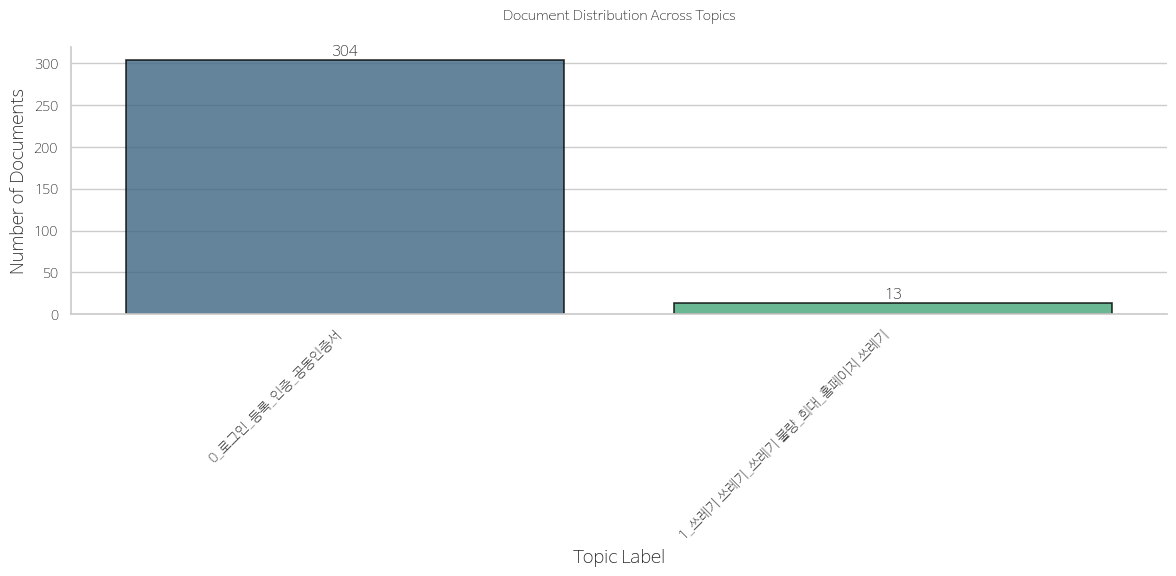

In [27]:
# ============================================================================
# Topic Distribution
# ============================================================================

# Calculate topic counts
topic_counts = doc_topics_df['topic_label'].value_counts().sort_values(ascending=False)

# Create enhanced bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=topic_counts.index, 
    y=topic_counts.values,
    palette='viridis',
    alpha=0.8,
    edgecolor='black',
    linewidth=1.2
)

# Add value labels
for i, v in enumerate(topic_counts.values):
    if 'KOREAN_FONT' in globals() and KOREAN_FONT:
        ax.text(i, v + 1, str(v), ha='center', va='bottom', 
                fontweight='bold', fontsize=11, fontproperties=KOREAN_FONT)
    else:
        ax.text(i, v + 1, str(v), ha='center', va='bottom', 
                fontweight='bold', fontsize=11)

# Styling with Korean font
if 'KOREAN_FONT' in globals() and KOREAN_FONT:
    plt.title('Document Distribution Across Topics', 
              fontsize=16, fontweight='bold', pad=20, fontproperties=KOREAN_FONT)
    plt.xlabel('Topic Label', fontsize=13, fontproperties=KOREAN_FONT)
    plt.ylabel('Number of Documents', fontsize=13, fontproperties=KOREAN_FONT)
    
    # ✅ CRITICAL: X축 tick labels에도 폰트 적용!
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=KOREAN_FONT, rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), fontproperties=KOREAN_FONT)
else:
    plt.title('Document Distribution Across Topics', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Topic Label', fontsize=13)
    plt.ylabel('Number of Documents', fontsize=13)
    plt.xticks(rotation=45, ha='right')

sns.despine()
plt.tight_layout()

# Save and display
plt.savefig(os.getcwd() + RESULT_PATH + 'topic_distribution_enhanced.png', 
            dpi=300, bbox_inches='tight')

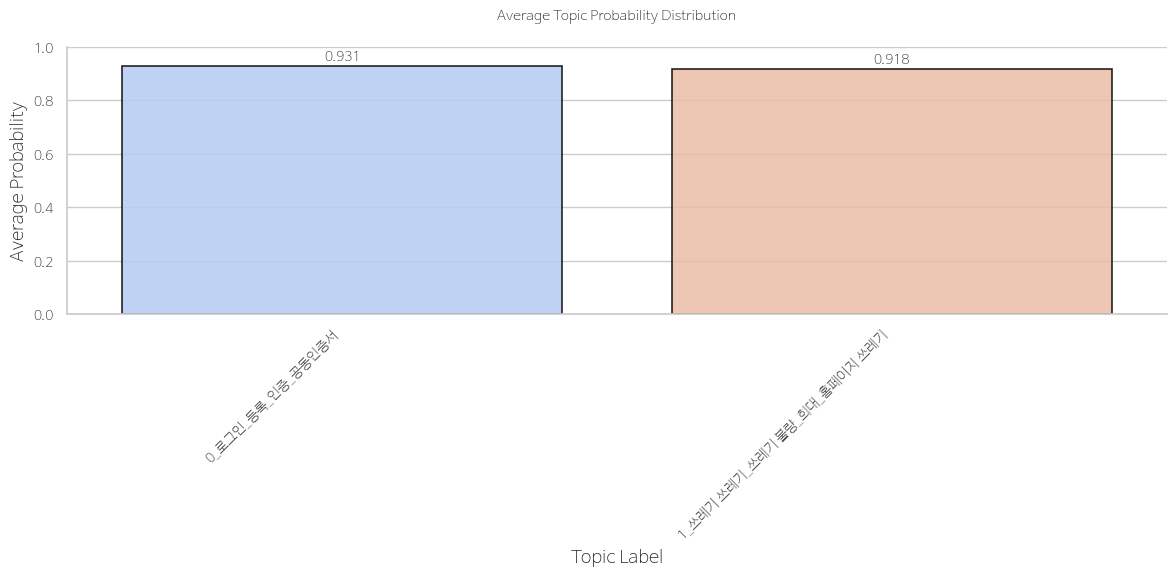

In [28]:
# ============================================================================
# Topic Probability 
# ============================================================================

# Calculate average probability per topic
prob_by_topic = (
    doc_topics_df
    .groupby('topic_label')['topic_probability']
    .mean()
    .sort_values(ascending=False)
)

# Create gradient-colored bar plot
plt.figure(figsize=(12, 6))
colors = sns.color_palette("coolwarm", len(prob_by_topic))
ax = sns.barplot(
    x=prob_by_topic.index,
    y=prob_by_topic.values,
    palette=colors,
    alpha=0.85,
    edgecolor='black',
    linewidth=1.2
)

# Add probability values on bars
for i, (topic, prob) in enumerate(prob_by_topic.items()):
    if 'KOREAN_FONT' in globals() and KOREAN_FONT:
        ax.text(i, prob + 0.02, f'{prob:.3f}', ha='center', 
                fontweight='bold', fontsize=10, fontproperties=KOREAN_FONT)
    else:
        ax.text(i, prob + 0.02, f'{prob:.3f}', ha='center', 
                fontweight='bold', fontsize=10)

# Styling with Korean font
if 'KOREAN_FONT' in globals() and KOREAN_FONT:
    plt.title('Average Topic Probability Distribution', 
              fontsize=16, fontweight='bold', pad=20, fontproperties=KOREAN_FONT)
    plt.xlabel('Topic Label', fontsize=13, fontproperties=KOREAN_FONT)
    plt.ylabel('Average Probability', fontsize=13, fontproperties=KOREAN_FONT)
    
    # ✅ CRITICAL: X축과 Y축 tick labels에 폰트 적용!
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=KOREAN_FONT, rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), fontproperties=KOREAN_FONT)
else:
    plt.title('Average Topic Probability Distribution', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Topic Label', fontsize=13)
    plt.ylabel('Average Probability', fontsize=13)
    plt.xticks(rotation=45, ha='right')

plt.ylim(0, 1.0)
sns.despine()
plt.tight_layout()

# Save and display
plt.savefig(os.getcwd() + RESULT_PATH + 'topic_probability_enhanced.png', 
            dpi=300, bbox_inches='tight')

## 5. Sentiment Analysis Integration

Combining topic modeling with sentiment analysis reveals:
- Which topics correlate with negative user experiences
- Satisfaction drivers vs. pain points
- Priority areas for UX improvements

**Sentiment Categories**:
- Positive: score ≥ 0.2
- Neutral: -0.2 < score < 0.2
- Negative: score ≤ -0.2

In [29]:
# 한국어 감성 분석 라이브러리 설치
!pip install transformers torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

print("\n Loading Korean sentiment model...")

# 사전 학습된 한국어 감성 분석 모델
model_name = "beomi/kcbert-base"  # 또는 "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.eval()  # 드롭아웃 비활성화

def predict_sentiment(text, max_length=128):
    """KcBERT 기반 감성 예측 (점수: 부정(-) ~ 긍정(+))"""
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding=True
    )

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)

    # 긍정 확률 - 부정 확률
    sentiment_score = probs[0][1].item() - probs[0][0].item()
    return sentiment_score

print("Analyzing sentiment for all documents...")
sentiment_scores = []

n_docs_bert = len(docs_for_bertopic)
print(f" docs_for_bertopic 개수: {n_docs_bert}")

for i, doc in enumerate(docs_for_bertopic):
    if i % 100 == 0:
        print(f"Progress: {i}/{n_docs_bert}")

    # docs_for_bertopic 은 토큰이 공백으로 join 된 상태이므로
    # 감성 분석용으로는 공백 제거해서 원문 비슷하게 사용
    text_for_sentiment = doc.replace(" ", "")
    score = predict_sentiment(text_for_sentiment[:512])  # 최대 512자
    sentiment_scores.append(score)

# ---- doc_topics_df와 길이 맞춰서 컬럼 추가 ----
n_scores = len(sentiment_scores)
n_topics_docs = len(doc_topics_df)

print(f" sentiment_scores: {n_scores}, doc_topics_df: {n_topics_docs}")

if n_scores != n_topics_docs:
    print(
        f"⚠ 경고: 감성 점수 개수({n_scores})와 doc_topics_df 행 수({n_topics_docs})가 다릅니다. "
        "짧은 쪽에 맞춰서 잘라서 사용합니다."
    )
    min_len = min(n_scores, n_topics_docs)
    sentiment_scores = sentiment_scores[:min_len]
    doc_topics_df = doc_topics_df.iloc[:min_len].copy()

doc_topics_df['sentiment_score'] = sentiment_scores

print(" Sentiment scores successfully attached to doc_topics_df.")

Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



 Loading Korean sentiment model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Analyzing sentiment for all documents...
 docs_for_bertopic 개수: 317
Progress: 0/317
Progress: 100/317
Progress: 200/317
Progress: 300/317
 sentiment_scores: 317, doc_topics_df: 317
 Sentiment scores successfully attached to doc_topics_df.


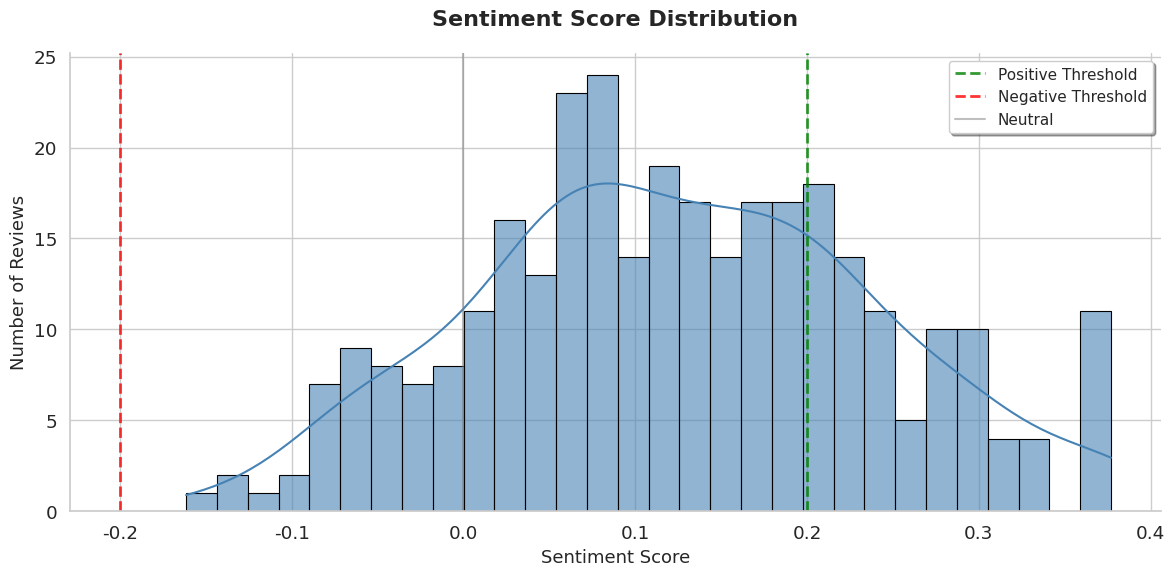

In [30]:
# ============================================================================
# Sentiment Distribution with KDE 
# ============================================================================
plt.figure(figsize=(12, 6))

# Create histogram with KDE overlay
sns.histplot(
    data=doc_topics_df, 
    x='sentiment_score',
    bins=30,
    kde=True,
    color='steelblue',
    alpha=0.6,
    edgecolor='black',
    linewidth=0.8
)

# Add reference lines for sentiment thresholds
plt.axvline(x=0.2, color='green', linestyle='--', linewidth=2, label='Positive Threshold', alpha=0.8)
plt.axvline(x=-0.2, color='red', linestyle='--', linewidth=2, label='Negative Threshold', alpha=0.8)
plt.axvline(x=0, color='gray', linestyle='-', linewidth=1.5, alpha=0.5, label='Neutral')

# Styling
plt.title('Sentiment Score Distribution', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Sentiment Score', fontsize=13)
plt.ylabel('Number of Reviews', fontsize=13)
plt.legend(loc='upper right', fontsize=11, frameon=True, shadow=True)
sns.despine()
plt.tight_layout()

# Save and display
plt.savefig(os.getcwd() + RESULT_PATH + 'sentiment_distribution_enhanced.png', dpi=300, bbox_inches='tight')

In [31]:
# ============================================================================
# Sentiment Categorization 
# ============================================================================

def label_sentiment(score, pos_threshold=0.2, neg_threshold=-0.2):
    """
    Categorize sentiment scores into three levels.
    
    Args:
        score (float): Sentiment polarity score
        pos_threshold (float): Minimum score for positive classification
        neg_threshold (float): Maximum score for negative classification
    
    Returns:
        str: 'Positive', 'Neutral', or 'Negative'
    """
    if score >= pos_threshold:
        return "Positive"
    elif score <= neg_threshold:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment categorization to create sentiment_label column
doc_topics_df['sentiment_label'] = doc_topics_df['sentiment_score'].apply(label_sentiment)

# Check the distribution
print("Sentiment distribution:")
print(doc_topics_df['sentiment_label'].value_counts())
print("\nDataFrame columns now include:")
print(doc_topics_df.columns.tolist())

Sentiment distribution:
sentiment_label
Neutral     231
Positive     86
Name: count, dtype: int64

DataFrame columns now include:
['doc_id', 'dominant_topic', 'tokens_preview', 'topic_probability', 'topic_label', 'sentiment_score', 'sentiment_label']


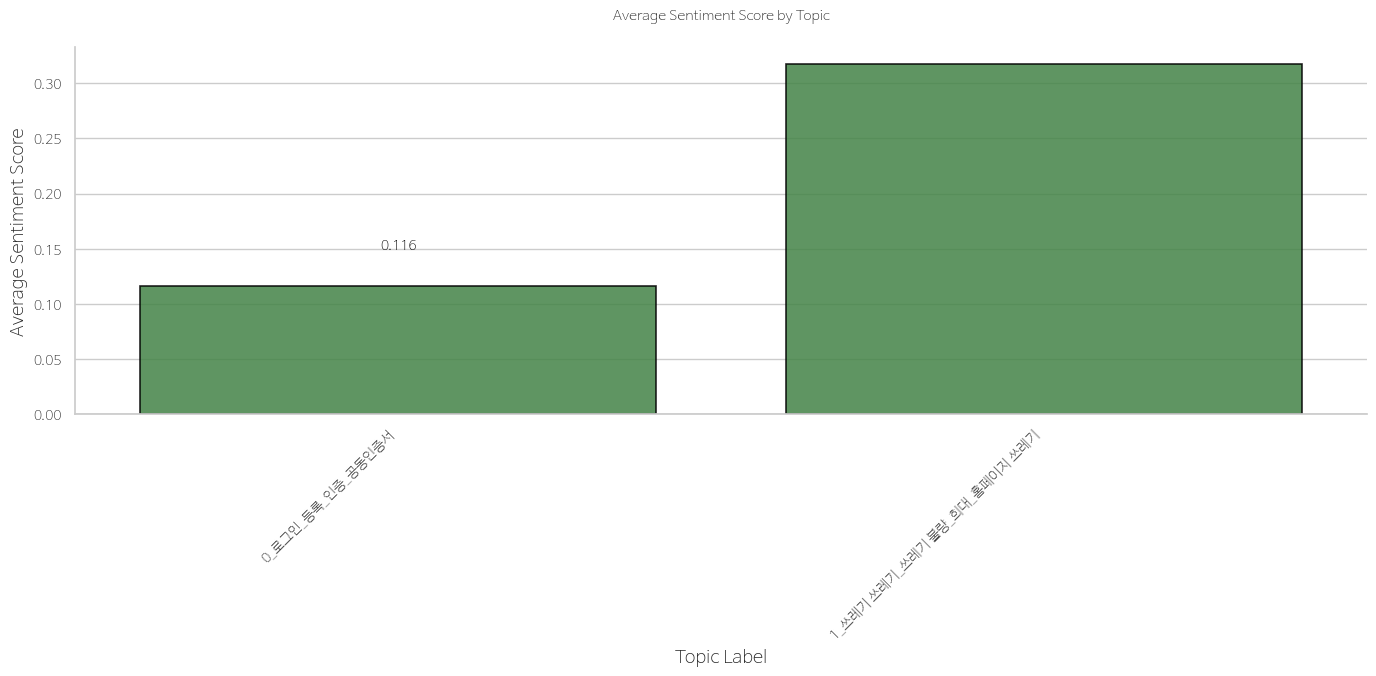

In [32]:
# ============================================================================
# Sentiment by Topic 
# ============================================================================
sentiment_by_topic = (
    doc_topics_df
    .groupby('topic_label')['sentiment_score']
    .mean()
    .sort_values()
)

plt.figure(figsize=(14, 7))

# Color bars based on sentiment polarity
colors_sentiment = [
    '#d32f2f' if x < -0.1 else '#388e3c' if x > 0.1 else '#757575' 
    for x in sentiment_by_topic.values
]

# Create bar plot
ax = sns.barplot(
    x=sentiment_by_topic.index,
    y=sentiment_by_topic.values,
    palette=colors_sentiment,
    alpha=0.85,
    edgecolor='black',
    linewidth=1.2
)

# Add value labels with smart positioning
for i, (topic, score) in enumerate(sentiment_by_topic.items()):
    y_pos = score + (0.03 if score >= 0 else -0.08)
    label_color = 'white' if abs(score) > 0.15 else 'black'
    
    if 'KOREAN_FONT' in globals() and KOREAN_FONT:
        ax.text(i, y_pos, f'{score:.3f}', 
                ha='center', 
                va='bottom' if score >= 0 else 'top',
                fontweight='bold',
                fontsize=10,
                color=label_color if abs(score) > 0.15 else 'black',
                fontproperties=KOREAN_FONT)
    else:
        ax.text(i, y_pos, f'{score:.3f}', 
                ha='center', 
                va='bottom' if score >= 0 else 'top',
                fontweight='bold',
                fontsize=10,
                color=label_color if abs(score) > 0.15 else 'black')

# Add neutral reference line
plt.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)

# Styling with Korean font
if 'KOREAN_FONT' in globals() and KOREAN_FONT:
    plt.title('Average Sentiment Score by Topic', 
              fontsize=16, fontweight='bold', pad=20, fontproperties=KOREAN_FONT)
    plt.xlabel('Topic Label', fontsize=13, fontproperties=KOREAN_FONT)
    plt.ylabel('Average Sentiment Score', fontsize=13, fontproperties=KOREAN_FONT)
    
    # ✅ CRITICAL: X축과 Y축 tick labels에 폰트 적용!
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=KOREAN_FONT, rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), fontproperties=KOREAN_FONT)
else:
    plt.title('Average Sentiment Score by Topic', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Topic Label', fontsize=13)
    plt.ylabel('Average Sentiment Score', fontsize=13)
    plt.xticks(rotation=45, ha='right')

sns.despine()
plt.tight_layout()

# Save and display
plt.savefig(os.getcwd() + RESULT_PATH + 'sentiment_by_topic_enhanced.png', 
            dpi=300, bbox_inches='tight')

In [33]:
# ============================================================================
# Interactive Plotly Heatmap 
# ============================================================================
pivot_data = doc_topics_df.pivot_table(
    index='topic_label',
    columns='sentiment_label',
    values='sentiment_score',
    aggfunc='count',
    fill_value=0
)

# Create interactive heatmap
fig = go.Figure(data=go.Heatmap(
    z=pivot_data.values,
    x=pivot_data.columns,
    y=pivot_data.index,
    colorscale='RdYlGn',
    text=pivot_data.values,
    texttemplate='%{text}',
    textfont={"size": 12, "family": "Arial Black"},
    hoverongaps=False,
    hovertemplate='<b>Topic</b>: %{y}<br>' +
                  '<b>Sentiment</b>: %{x}<br>' +
                  '<b>Count</b>: %{z}<extra></extra>',
    colorbar=dict(title="Review Count")
))

# Update layout
fig.update_layout(
    title={
        'text': 'Topic-Sentiment Distribution Heatmap',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18, 'family': 'Arial Black'}
    },
    xaxis_title='Sentiment Category',
    yaxis_title='Topic',
    width=900,
    height=600,
    font=dict(size=12),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Save and display
fig.write_html(os.getcwd() + RESULT_PATH + 'topic_sentiment_heatmap.html')
print(" Saved: topic_sentiment_heatmap.html")

 Saved: topic_sentiment_heatmap.html


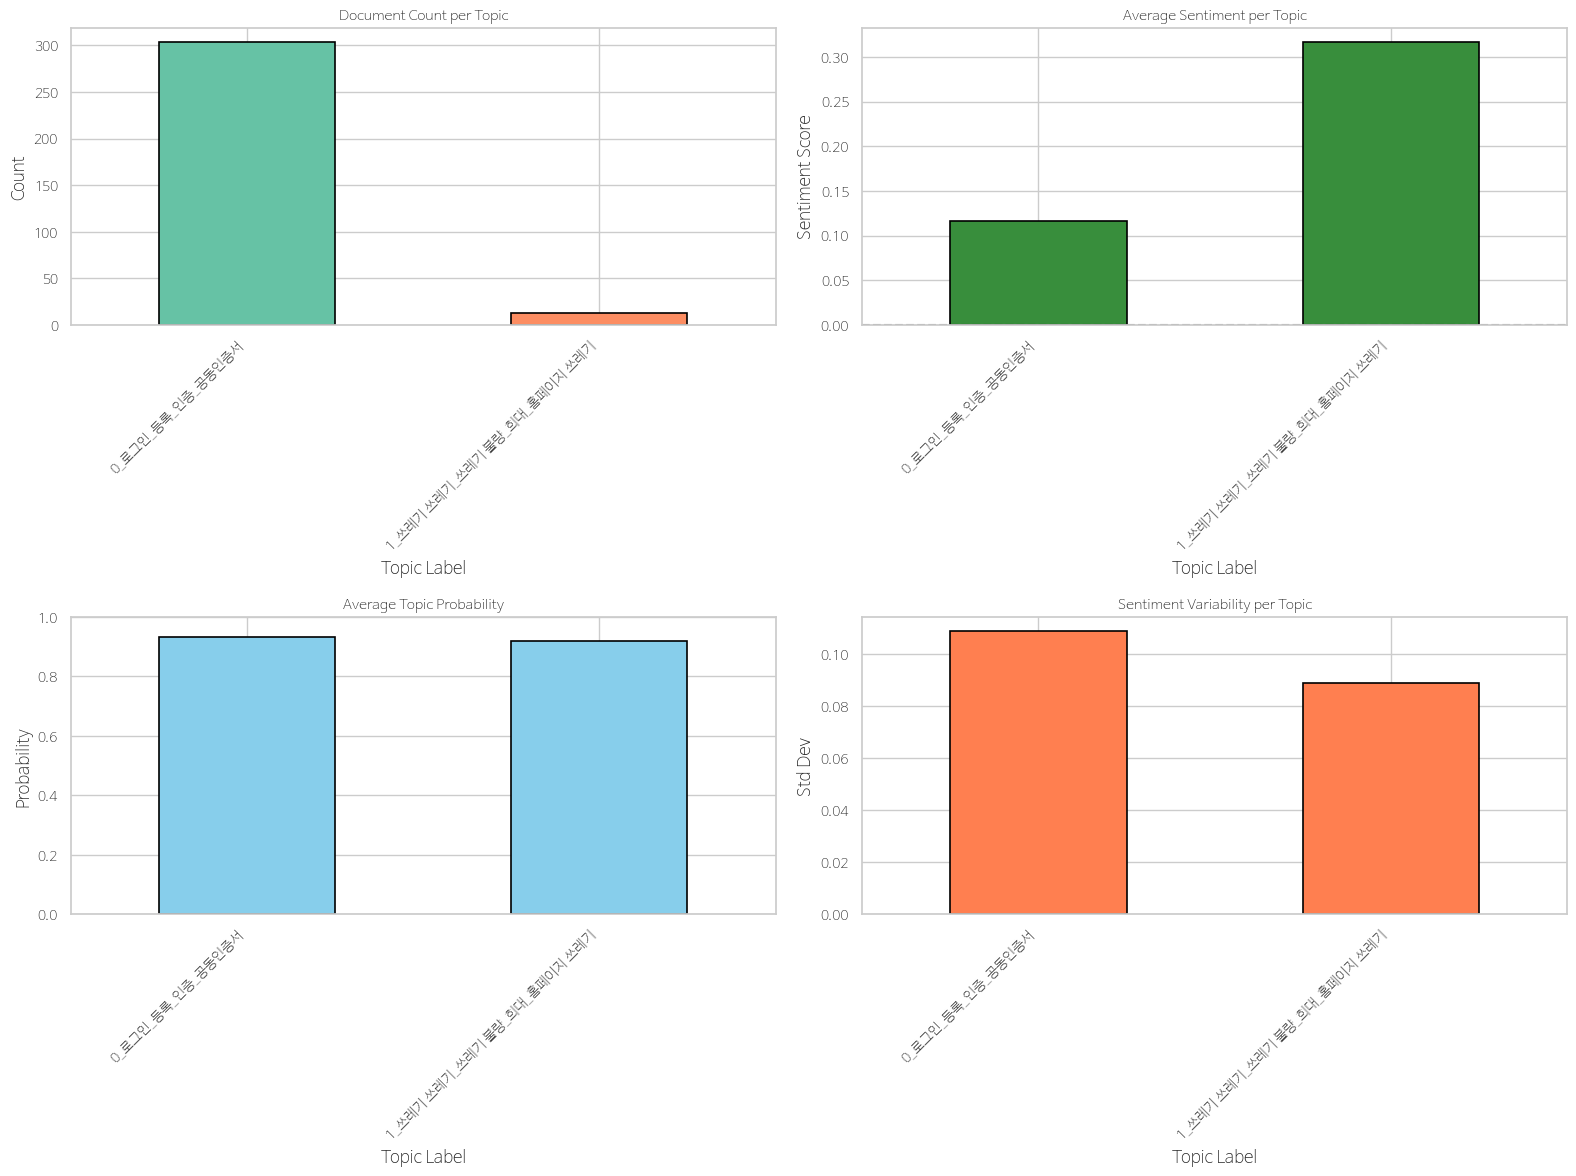


TOPIC SUMMARY STATISTICS
                              Avg_Sentiment  Std_Sentiment  Doc_Count  Avg_Probability
topic_label                                                                           
0_로그인_등록_인증_공동인증서                     0.116          0.109        304            0.931
1_쓰레기 쓰레기_쓰레기 불량_희대_홈페이지 쓰레기          0.317          0.089         13            0.918


In [34]:
# ============================================================================
# Comprehensive Topic Summary
# ============================================================================
topic_summary = doc_topics_df.groupby('topic_label').agg({
    'sentiment_score': ['mean', 'std', 'count'],
    'topic_probability': 'mean'
}).round(3)

topic_summary.columns = ['Avg_Sentiment', 'Std_Sentiment', 'Doc_Count', 'Avg_Probability']
topic_summary = topic_summary.sort_values('Doc_Count', ascending=False)

# Create multi-panel figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ============================================================================
# Panel 1: Document counts
# ============================================================================
ax1 = axes[0, 0]
topic_summary['Doc_Count'].plot(kind='bar', ax=ax1, color=COLORS_TOPICS[:len(topic_summary)], 
                                 edgecolor='black', linewidth=1.2)

if 'KOREAN_FONT' in globals() and KOREAN_FONT:
    ax1.set_title('Document Count per Topic', fontsize=14, fontweight='bold', fontproperties=KOREAN_FONT)
    ax1.set_xlabel('Topic Label', fontsize=12, fontproperties=KOREAN_FONT)
    ax1.set_ylabel('Count', fontsize=12, fontproperties=KOREAN_FONT)
    ax1.set_xticklabels(ax1.get_xticklabels(), fontproperties=KOREAN_FONT, rotation=45, ha='right')
    ax1.set_yticklabels(ax1.get_yticklabels(), fontproperties=KOREAN_FONT)
else:
    ax1.set_title('Document Count per Topic', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Topic Label', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)

# ============================================================================
# Panel 2: Average sentiment
# ============================================================================
ax2 = axes[0, 1]
colors_sent = ['#d32f2f' if x < -0.05 else '#388e3c' if x > 0.05 else '#757575' 
               for x in topic_summary['Avg_Sentiment']]
topic_summary['Avg_Sentiment'].plot(kind='bar', ax=ax2, color=colors_sent, 
                                     edgecolor='black', linewidth=1.2)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)

if 'KOREAN_FONT' in globals() and KOREAN_FONT:
    ax2.set_title('Average Sentiment per Topic', fontsize=14, fontweight='bold', fontproperties=KOREAN_FONT)
    ax2.set_xlabel('Topic Label', fontsize=12, fontproperties=KOREAN_FONT)
    ax2.set_ylabel('Sentiment Score', fontsize=12, fontproperties=KOREAN_FONT)
    ax2.set_xticklabels(ax2.get_xticklabels(), fontproperties=KOREAN_FONT, rotation=45, ha='right')
    ax2.set_yticklabels(ax2.get_yticklabels(), fontproperties=KOREAN_FONT)
else:
    ax2.set_title('Average Sentiment per Topic', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Topic Label', fontsize=12)
    ax2.set_ylabel('Sentiment Score', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)

# ============================================================================
# Panel 3: Topic probability
# ============================================================================
ax3 = axes[1, 0]
topic_summary['Avg_Probability'].plot(kind='bar', ax=ax3, color='skyblue', 
                                       edgecolor='black', linewidth=1.2)

if 'KOREAN_FONT' in globals() and KOREAN_FONT:
    ax3.set_title('Average Topic Probability', fontsize=14, fontweight='bold', fontproperties=KOREAN_FONT)
    ax3.set_xlabel('Topic Label', fontsize=12, fontproperties=KOREAN_FONT)
    ax3.set_ylabel('Probability', fontsize=12, fontproperties=KOREAN_FONT)
    ax3.set_xticklabels(ax3.get_xticklabels(), fontproperties=KOREAN_FONT, rotation=45, ha='right')
    ax3.set_yticklabels(ax3.get_yticklabels(), fontproperties=KOREAN_FONT)
else:
    ax3.set_title('Average Topic Probability', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Topic Label', fontsize=12)
    ax3.set_ylabel('Probability', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)

ax3.set_ylim(0, 1)

# ============================================================================
# Panel 4: Sentiment standard deviation
# ============================================================================
ax4 = axes[1, 1]
topic_summary['Std_Sentiment'].plot(kind='bar', ax=ax4, color='coral', 
                                     edgecolor='black', linewidth=1.2)

if 'KOREAN_FONT' in globals() and KOREAN_FONT:
    ax4.set_title('Sentiment Variability per Topic', fontsize=14, fontweight='bold', fontproperties=KOREAN_FONT)
    ax4.set_xlabel('Topic Label', fontsize=12, fontproperties=KOREAN_FONT)
    ax4.set_ylabel('Std Dev', fontsize=12, fontproperties=KOREAN_FONT)
    ax4.set_xticklabels(ax4.get_xticklabels(), fontproperties=KOREAN_FONT, rotation=45, ha='right')
    ax4.set_yticklabels(ax4.get_yticklabels(), fontproperties=KOREAN_FONT)
else:
    ax4.set_title('Sentiment Variability per Topic', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Topic Label', fontsize=12)
    ax4.set_ylabel('Std Dev', fontsize=12)
    ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.getcwd() + RESULT_PATH + 'comprehensive_topic_summary.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Print summary table
print("\n" + "="*80)
print("TOPIC SUMMARY STATISTICS")
print("="*80)
print(topic_summary.to_string())
print("="*80)

Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating word clouds for each topic...


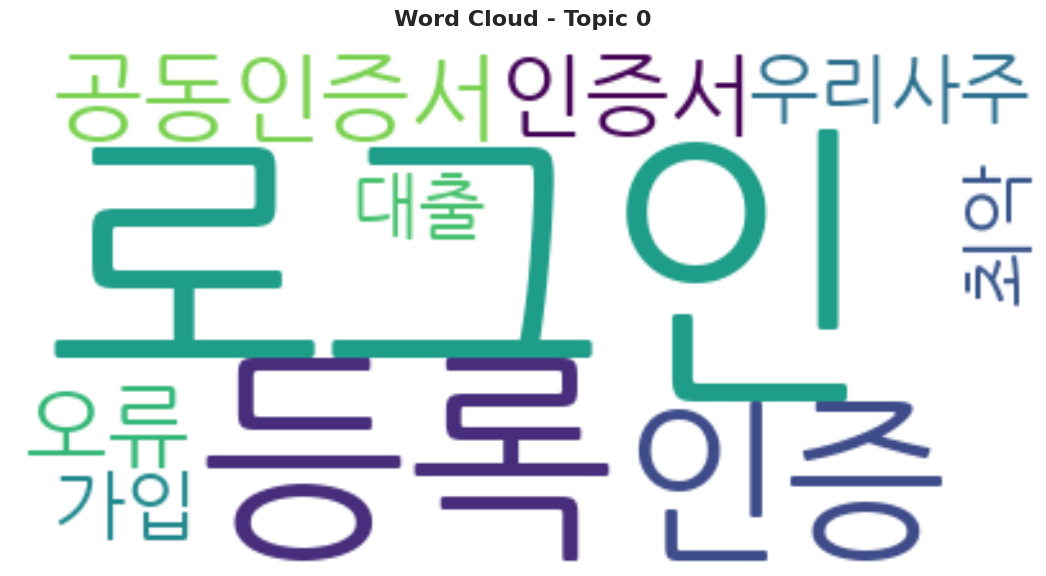

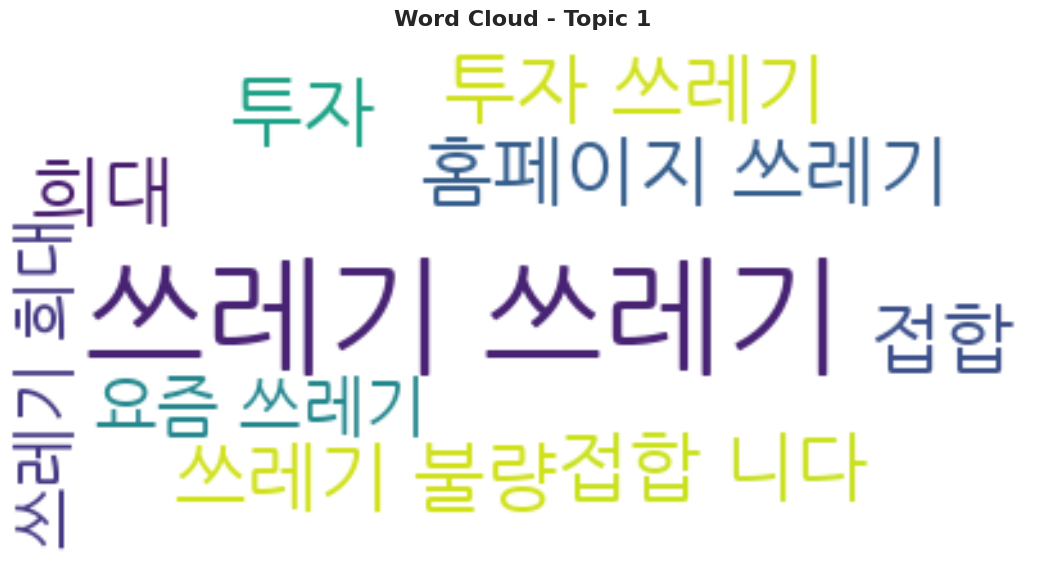

 Word clouds generated


In [35]:
!pip install wordcloud

# ============================================================================
# Word Cloud per Topic 
# ============================================================================
# Install wordcloud if needed: pip install wordcloud
from wordcloud import WordCloud

def create_korean_wordcloud(topic_id, max_words=30):
    """
    Generate word cloud for a specific topic.
    
    Args:
        topic_id: Topic number/label
        max_words: Maximum number of words to display
    """
    # Get top words for this topic
    topic_words = topic_model.get_topic(topic_id)
    
    if not topic_words or topic_words == []:
        print(f"No words found for topic {topic_id}")
        return
    
    # Create word frequency dictionary
    word_freq = {word: score for word, score in topic_words[:max_words]}
    
    # Generate word cloud
    wordcloud = WordCloud(
        font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # Adjust path if needed
        width=400,
        height=200,
        background_color='white',
        colormap='viridis',
        relative_scaling=0.5,
        min_font_size=10
    ).generate_from_frequencies(word_freq)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - Topic {topic_id}', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(os.getcwd() + RESULT_PATH + f'wordcloud_topic_{topic_id}.png', 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# Generate word clouds for all valid topics
print("Generating word clouds for each topic...")

# Get topics directly from model
topic_info = topic_model.get_topic_info()
valid_topics = [t for t in topic_info['Topic'] if t != -1][:NUM_TOPICS]

for topic_id in valid_topics[:NUM_TOPICS]:  # Limit to NUM_TOPICS
    create_korean_wordcloud(topic_id)
print(" Word clouds generated")

## 5. Results & Interpretation

### Key Findings
- **Topic 0 (Emotional Complaints)**: Represents extreme dissatisfaction, primarily consisting of 
  non-constructive criticism. These reviews offer limited actionable insights.
- **Topic 1 (Functional Issues)**: The dominant topic capturing specific UX pain points around 
  authentication workflows, login persistence, and app stability.

### Business Recommendations
1. Prioritize streamlining the certificate registration and login flow
2. Implement session persistence to reduce repeated authentication
3. Address app performance issues (buffering, loading times)

### Limitations
- Dataset is heavily skewed toward 1-star and 5-star reviews
- Small sample size (317 documents) limits topic granularity
- Korean morphological analysis may miss some compound terms